In [1]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

In [2]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [3]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# hide
# no_test
# conditionally load nb_black cell magic
import sys

if "google.colab" not in sys.modules:
    from IPython import get_ipython

    ipython = get_ipython()
    ipython.magic("reload_ext lab_black")

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

import geowrangler.vector_zonal_stats as vzs

/home/butchtm/work/ai4d/geowrangler/.venv/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Vector Zonal Stats Tutorial

> A basic introduction to Vector Zonal Stats 

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/tutorial.vector_zonal_stats.ipynb)


## Basic Usage

Generate zonal stats for a GeoDataframe containing areas of interest

Terms:

* **aoi** - Area of Interest: a geodataframe which we are interested in generating zonal statistics for
* **data** - Data: the source geodataframe containing data


#### Usecase 1 - Count POIs (Points of Interest) 

* Example 1

   * Input: 
      - aoi - region3,4,ncr regions (Admin Level 1) (Central Luzon) geometry (geom_type - polygon, multipolygon)
      - data - Philippine pois (geom_type - points) 
      - overlap_method = 'intersects'
      - aggregations:
         * count 
            - number of pois within aoi
  * Output
    - aoi with pois count (default output column: `aoi_index_count`)

In [6]:
%%time
# area multipolygons for regions 3,4,ncr of the philippines
aoi = gpd.read_file("../data/region34ncr_admin.geojson")

CPU times: user 2.88 s, sys: 277 ms, total: 3.16 s
Wall time: 3.15 s


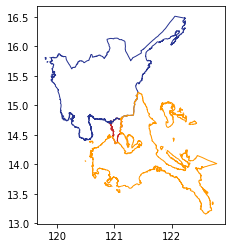

In [7]:
# no_test
ax = aoi.plot(
    ax=plt.axes(),
    facecolor="none",
    edgecolor=[
        "#C62828",
        "#283593",
        "#FF9800",
    ],
)

In [8]:
aoi

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ..."
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ..."


In [9]:
%%time
# raw pois from osm data (subset of region3,4, ncr only)
raw_data = gpd.read_file("../data/region34ncr_osm_pois.geojson")

CPU times: user 166 ms, sys: 809 µs, total: 167 ms
Wall time: 165 ms


In [10]:
%%time
aoi = vzs.create_zonal_stats(
    aoi,
    raw_data,
    overlap_method="intersects",
    aggregations=[{"func": "count"}],
)

CPU times: user 104 ms, sys: 589 µs, total: 105 ms
Wall time: 103 ms


In [11]:
%%time
# no_test
aoi

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.25 µs


,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,aoi_index_count
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ...",880
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",701
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ...",1253


In [12]:
# hide
# drop newly created zonal stat
aoi.drop(labels=["aoi_index_count"], inplace=True, axis=1)

* Example 2

   * Input: 
      - aoi - region3,4,ncr regions (Admin Level 1) (Central Luzon, NCR, Calabarzon) geometry (geom_type - polygon, multipolygon)
      - attractions - filtered Philippine pois (Central Luzon, NCR, Calabarzon only) (geom_type - points) with `fclass` == 'attraction' 
      - overlap_method = 'intersects'
      - aggregations:
         * count 
            - number of pois within aoi
            - output column name `attractions`
  * Output
    - aoi with pois count

In [13]:
# hide
# select only 'attraction' pois
attractions = raw_data[raw_data.fclass == "attraction"]

In [14]:
# hide
aoi_attr = vzs.create_zonal_stats(aoi, attractions, aggregations=[{"func": "count"}])

In [15]:
# hide
assert [*list(aoi.columns.values), "aoi_index_count"] == list(aoi_attr.columns.values)

In [16]:
# hide
len(aoi_attr) == len(aoi)

True

In [17]:
# hide
assert aoi_attr.drop("aoi_index_count", axis=1).equals(aoi)

In [18]:
# hide
assert [136, 205, 312] == aoi_attr[["aoi_index_count"]].values.flatten().tolist()

Add `output` key to specify output column name for count

In [19]:
%%time
aoi_attr = vzs.create_zonal_stats(
    aoi, attractions, aggregations=[{"func": "count", "output": "attractions"}]
)

CPU times: user 123 ms, sys: 279 µs, total: 124 ms
Wall time: 121 ms


In [20]:
# no_test
aoi_attr

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,attractions
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ...",136
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",205
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ...",312


In [21]:
# hide
assert [*list(aoi.columns.values), "attractions"] == list(aoi_attr.columns.values)

* Example 3

   * Input: 
      - aoi - gridded tiles for Region 3 (Central Luzon) at 15km x 15km size 
      - data - region 3 data filtered from philippine pois (geom_type - points) 
      - overlap_method = 'intersects'
      - aggregations:
         * count 
            - number of pois within aoi
            - output column name
  * Output
    - aoi with pois count

In [22]:
%%time
# load gridded tiles
grid_aoi = gpd.read_file("../data/region3_admin_grids.geojson")

CPU times: user 135 ms, sys: 20.5 ms, total: 155 ms
Wall time: 136 ms


In [23]:
%%time
region3_pois = gpd.read_file("../data/region3_osm_pois.geojson")

CPU times: user 80.4 ms, sys: 924 µs, total: 81.3 ms
Wall time: 79.9 ms


In [24]:
region3_pois.head()

,osm_id,code,fclass,name,BARANGAY_CODE,geometry
0,560410986,2701,tourist_info,Gawad Kalinga Office,031420009,POINT (121.08516 14.83601)
1,1244301672,2701,tourist_info,"N 15deg 26' 11.1"", E 120deg 25' 50.2"", El...",036918006,POINT (120.43045 15.43663)
2,1666684393,2701,tourist_info,Eco Park Tourist Information & DENR Environmen...,036918006,POINT (120.44958 15.46446)
3,1679992929,2701,tourist_info,La Paz Tarlac - Zaragoza Nueva Ecija Boundary,034932027,POINT (120.75832 15.44284)
4,1714645729,2701,tourist_info,Lucy Pineda,035409019,POINT (120.61452 15.23359)


In [25]:
len(region3_pois)

701

In [26]:
grid_aoi.columns.values

array(['x', 'y', 'geometry'], dtype=object)

In [27]:
region3_pois.columns.values

array(['osm_id', 'code', 'fclass', 'name', 'BARANGAY_CODE', 'geometry'],
      dtype=object)

In [28]:
%%time
grid_aoi = vzs.create_zonal_stats(
    grid_aoi,
    region3_pois,
    overlap_method="intersects",
    aggregations=[{"func": "count", "output": "pois_count"}],
)
grid_aoi.head()

CPU times: user 32.6 ms, sys: 10.3 ms, total: 42.9 ms
Wall time: 40.2 ms


,x,y,geometry,pois_count
0,0,30,"POLYGON ((119.78583 15.70870, 119.83075 15.708...",0.0
1,0,31,"POLYGON ((119.78583 15.75193, 119.83075 15.751...",0.0
2,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795...",0.0
3,1,30,"POLYGON ((119.83075 15.70870, 119.87566 15.708...",0.0
4,1,32,"POLYGON ((119.83075 15.79516, 119.87566 15.795...",0.0


In [29]:
grid_aoi.pois_count.sum()

701.0

In [30]:
# hide
assert grid_aoi.pois_count.sum() == len(region3_pois)

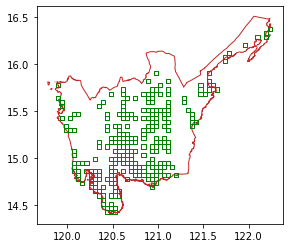

In [31]:
# no_test
# show grids with at least 1 poi
ax = aoi[aoi.Reg_Name == "Region III"].plot(
    ax=plt.axes(),
    facecolor="none",
    edgecolor=[
        "#C62828",
    ],
)
ax = grid_aoi[grid_aoi.pois_count > 0].plot(ax=ax, facecolor="none", edgecolor="green")

#### Usecase 2 - Stats on a metric column

** Example 1 **
* input: 
    - aoi - region3,4,ncr geometry (geom_type - polygon, multipolygon)
    - data - region3,4, ncr population data (geom_type - pois) 
    - data_type: 'individual_pois'
    - overlap_method = 'intersects'
    - aggregations:
        * metric_columns: 'population','men', etc.  
            - each row in the data has a column population, men, women, etc with numeric value
            - aggregation_functions - 'min','max', 'mean', 'sum',  etc.
            - output_columns - 'pop_min', 'pop_max', for each 
  

Load 2020 Region3,4,NCR Population Data at Barangay level (Admin Level 4)

In [32]:
%%time
# load region3,4,ncr population data at barangay level
region34ncr_pop_data = gpd.read_file("../data/region34ncr_population_land.geojson")

CPU times: user 759 ms, sys: 20.4 ms, total: 779 ms
Wall time: 777 ms


In [33]:
len(region34ncr_pop_data)

8816

In [34]:
region34ncr_pop_data.head()

,BARANGAY_CODE,population,men,women,children_under_five,youth_15_24,women_of_reproductive_age_15_49,elderly_60_plus,land_area,geometry
0,31420020.0,1807,920,887,202,359,468,77,2.183518e+05,POINT (121.05919 14.85825)
1,34915006.0,3093,1594,1499,352,658,826,159,7.327482e+06,POINT (120.99590 15.62242)
2,35403009.0,4241,2158,2083,474,821,1112,256,8.740450e+05,POINT (120.77730 15.14580)
3,35409023.0,3373,1750,1623,296,611,895,244,6.484611e+05,POINT (120.58052 15.22315)
4,35413009.0,20884,10539,10344,2198,3893,5589,1260,2.015571e+06,POINT (120.68523 15.09163)


In [35]:
region34ncr_pop_data.columns.values

array(['BARANGAY_CODE', 'population', 'men', 'women',
       'children_under_five', 'youth_15_24',
       'women_of_reproductive_age_15_49', 'elderly_60_plus', 'land_area',
       'geometry'], dtype=object)

In [36]:
%%time
aoi = vzs.create_zonal_stats(
    aoi,
    region34ncr_pop_data,
    aggregations=[
        {"func": "count", "output": "bgy_count"},
        {
            "column": "population",
            "func": ["sum", "mean"],
            "output": ["pop_total", "pop_avg"],
        },
        {"column": "men", "func": ["sum", "mean"], "output": ["men_total", "men_avg"]},
        {
            "column": "women",
            "func": ["sum", "mean"],
            "output": ["women_total", "women_avg"],
        },
        {
            "column": "children_under_five",
            "func": ["sum", "mean"],
            "output": ["under5_total", "under5_avg"],
        },
        {
            "column": "youth_15_24",
            "func": ["sum", "mean"],
            "output": ["youth_total", "youth_avg"],
        },
        {
            "column": "women_of_reproductive_age_15_49",
            "func": ["sum", "mean"],
            "output": ["women_repro_total", "women_repro_avg"],
        },
        {
            "column": "elderly_60_plus",
            "func": ["sum", "mean"],
            "output": ["elderly_total", "elderly_avg"],
        },
        {
            "column": "land_area",
            "func": ["sum", "mean", "min", "max", "std"],
            "output": ["land_total", "land_avg", "land_min", "land_max", "land_std"],
        },
    ],
    overlap_method="intersects",
)

CPU times: user 205 ms, sys: 9.41 ms, total: 214 ms
Wall time: 212 ms


In [37]:
aoi.columns.values

array(['Reg_Code', 'Reg_Name', 'Reg_Alt_Name', 'geometry', 'bgy_count',
       'pop_total', 'pop_avg', 'men_total', 'men_avg', 'women_total',
       'women_avg', 'under5_total', 'under5_avg', 'youth_total',
       'youth_avg', 'women_repro_total', 'women_repro_avg',
       'elderly_total', 'elderly_avg', 'land_total', 'land_avg',
       'land_min', 'land_max', 'land_std'], dtype=object)

In [38]:
aoi.head()

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,bgy_count,pop_total,pop_avg,men_total,men_avg,women_total,...,youth_avg,women_repro_total,women_repro_avg,elderly_total,elderly_avg,land_total,land_avg,land_min,land_max,land_std
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ...",1707,12484535,7313.728764,6132828,3592.752197,6350844,...,1468.077329,3699839,2167.451084,653306,382.721734,5.945955e+08,3.483277e+05,2890.947906,2.750653e+07,1.065422e+06
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",3099,10581859,3414.604389,5353309,1727.431107,5227035,...,655.773475,2808810,906.360116,664150,214.311068,2.120885e+10,6.843771e+06,9589.467114,3.496501e+08,1.826504e+07
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ...",4010,14081857,3511.685037,7035334,1754.447382,7044548,...,671.226185,3857217,961.899501,780294,194.587032,1.551525e+10,3.869139e+06,3087.452331,4.310269e+08,1.119929e+07


** Example 2 **
* input: 
    - aoi - region3 grids geometry (geom_type - polygon)
    - data - population data (geom_type - pois) 
    - data_type: 'individual_pois'
    - overlap_method = 'intersects'
    - aggregations:
        * metric_columns: 'population','men', 'land_area'   
            - each row in the data has a column population numeric value
            - aggregation_functions - 'min','max', 'mean', 'sum',  etc.
            - output_columns - 'pop_min', 'pop_max', for each 
  

Filter population POIs only in region 3

In [39]:
%%time
region3_pop_pois = gpd.read_file("../data/region3_population_pois.geojson")

CPU times: user 273 ms, sys: 36 µs, total: 273 ms
Wall time: 271 ms


In [40]:
region3_pop_pois.head()

,BARANGAY_CODE,population,men,women,children_under_five,youth_15_24,women_of_reproductive_age_15_49,elderly_60_plus,land_area,Reg_Name,geometry
0,31420020.0,1807,920,887,202,359,468,77,2.183518e+05,Region III,POINT (121.05919 14.85825)
1,34915006.0,3093,1594,1499,352,658,826,159,7.327482e+06,Region III,POINT (120.99590 15.62242)
2,35403009.0,4241,2158,2083,474,821,1112,256,8.740450e+05,Region III,POINT (120.77730 15.14580)
3,35409023.0,3373,1750,1623,296,611,895,244,6.484611e+05,Region III,POINT (120.58052 15.22315)
4,35413009.0,20884,10539,10344,2198,3893,5589,1260,2.015571e+06,Region III,POINT (120.68523 15.09163)


In [41]:
region3_pop_pois.columns.values

array(['BARANGAY_CODE', 'population', 'men', 'women',
       'children_under_five', 'youth_15_24',
       'women_of_reproductive_age_15_49', 'elderly_60_plus', 'land_area',
       'Reg_Name', 'geometry'], dtype=object)

In [42]:
%%time
grid_aoi = vzs.create_zonal_stats(
    grid_aoi,
    region3_pop_pois,
    aggregations=[
        {"func": "count", "output": "bgy_count"},
        {
            "column": "population",
            "func": ["sum", "mean"],
            "output": ["pop_total", "pop_avg"],
        },
        {"column": "men", "func": ["sum", "mean"], "output": ["men_total", "men_avg"]},
        {
            "column": "women",
            "func": ["sum", "mean"],
            "output": ["women_total", "women_avg"],
        },
        {
            "column": "children_under_five",
            "func": ["sum", "mean"],
            "output": ["under5_total", "under5_avg"],
        },
        {
            "column": "youth_15_24",
            "func": ["sum", "mean"],
            "output": ["youth_total", "youth_avg"],
        },
        {
            "column": "women_of_reproductive_age_15_49",
            "func": ["sum", "mean"],
            "output": ["women_repro_total", "women_repro_avg"],
        },
        {
            "column": "elderly_60_plus",
            "func": ["sum", "mean"],
            "output": ["elderly_total", "elderly_avg"],
        },
        {
            "column": "land_area",
            "func": ["sum", "mean", "min", "max", "std"],
            "output": ["land_total", "land_avg", "land_min", "land_max", "land_std"],
        },
    ],
    overlap_method="intersects",
)

CPU times: user 93.3 ms, sys: 225 µs, total: 93.5 ms
Wall time: 89.2 ms


In [43]:
# no_test
grid_aoi.head()

,x,y,geometry,pois_count,bgy_count,pop_total,pop_avg,men_total,men_avg,women_total,...,youth_avg,women_repro_total,women_repro_avg,elderly_total,elderly_avg,land_total,land_avg,land_min,land_max,land_std
0,0,30,"POLYGON ((119.78583 15.70870, 119.83075 15.708...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,0,31,"POLYGON ((119.78583 15.75193, 119.83075 15.751...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,1,30,"POLYGON ((119.83075 15.70870, 119.87566 15.708...",0.0,1.0,3415.0,3415.0,1744.0,1744.0,1670.0,...,648.0,848.0,848.0,229.0,229.0,5.552401e+06,5.552401e+06,5.552401e+06,5.552401e+06,0.0
4,1,32,"POLYGON ((119.83075 15.79516, 119.87566 15.795...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [44]:
# hide
assert any(
    item
    in [
        "land_total",
        "land_avg",
        "land_min",
        "land_max",
        "land_std",
        "elderly_total",
        "elderly_avg",
        "women_repro_total",
        "women_repro_avg",
        "under5_total",
        "under5_avg",
        "women_total",
        "women_avg",
        "men_total",
        "men_avg",
        "pop_total",
        "pop_avg",
        "bgy_count",
    ]
    for item in list(grid_aoi.columns.values)
)

In [45]:
import matplotlib.pyplot as plt

Show grids with bgy_count > 0 and bgy_count == 0

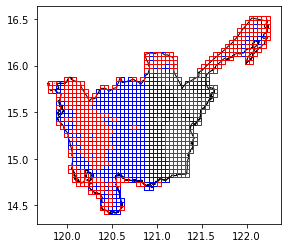

In [46]:
# no_test
ax = aoi[aoi.Reg_Name == "Region III"].plot(
    ax=plt.axes(), facecolor="none", edgecolor="black"
)
ax = grid_aoi[grid_aoi.bgy_count > 0.0].plot(ax=ax, facecolor="none", edgecolor="blue")
ax = grid_aoi[grid_aoi.bgy_count == 0.0].plot(ax=ax, facecolor="none", edgecolor="red")